### Bio Clustering (Word2Vec and Kmeans Clustering)

In [390]:
import pandas as pd
import numpy as np
from time import time
import re
import os
import nltk
# import gensim.models.word2vec as w2v

nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import multiprocessing

import seaborn as sns
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import sklearn.manifold

[nltk_data] Downloading package punkt to /home/paraz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/paraz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading file and creating dataframe

In [154]:
with open("_data/unlabled/bio_1501598612.022413.txt") as f:
    all_data = f.read().split('\n')

In [163]:
def clean_sentence(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

In [173]:
df = pd.DataFrame(all_data, columns=['bio'])
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()

df = pd.DataFrame(df['bio'].apply(clean_sentence))
df.drop_duplicates(inplace=True)
df.count()

bio    13364
dtype: int64

#### Data Details

In [188]:
df.describe()

,bio
count,13364
unique,13364
top,Promoting Good Transparent Governance Vande Ma...
freq,1


In [193]:
df['word_freq'] = df['bio'].apply(lambda x: len(x.split()))

#### Average sentence length

In [195]:
df['word_freq'].mean()

10.4408111343909

'Patrick'

### Word2Vec Feature Extraction

In [298]:
def sentence_to_wordlist(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text.lower())
    return tokens

In [299]:
sentences = []
for raw_sentence in df['bio']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [301]:
sentences[909]

['an',
 'online',
 'master',
 'information',
 'data',
 'science',
 'mids',
 'degree',
 'uc',
 'berkeley',
 'school',
 'information',
 'learn']

In [304]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 139,560 tokens


**Word2Vec model**



In [307]:
# Dimensionality of the resulting word vectors.
# more dimensions mean more training them, but more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3
# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7
# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3
# Seed for the RNG, to make the results reproducible.
seed = 1

In [320]:
t0 = time()
bio_vec = w2v.Word2Vec(
    sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    iter = 10
)

print("Train Time:", time()-t0)

Train Time: 23.048173666000366


In [325]:
if not os.path.exists("_data/trained"):
    os.makedirs("_data/trained")

bio_vec.save(os.path.join("_data/trained", "bioVectors.w2v"))

In [363]:
bio_vec.most_similar_cosmul("machine")

[('deep', 0.9725673794746399),
 ('machinelearning', 0.9669541716575623),
 ('ai', 0.9660089015960693),
 ('learning', 0.9648625254631042),
 ('computational', 0.9612101912498474),
 ('ml', 0.9610495567321777),
 ('nlp', 0.9576761722564697),
 ('deeplearning', 0.9536548852920532),
 ('algorithms', 0.9533912539482117),
 ('brain', 0.9521350860595703)]

In [377]:
print("Vocab Size:", len(bio_vec.wv.vocab.keys()))

Vocab Size: 6339


### Visualization and word-D-reduction

In [384]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = bio_vec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

KeyboardInterrupt: 

In [385]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[bio_vec.wv.vocab[word].index])
            for word in bio_vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

NameError: name 'all_word_vectors_matrix_2d' is not defined

In [386]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=30, figsize=(30, 22))
plt.show()

NameError: name 'sns' is not defined

In [389]:
def plot_region(x_bounds, y_bounds):
    try:
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]

        ax = slice.plot.scatter("x", "y", s=90, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    except:
        print("No word in this region")

In [388]:
plot_region(x_bounds=(0,1.9), y_bounds=(-0.1, 1.5))

plt.show()

NameError: name 'plot_region' is not defined

### Dimensionality Reduction

In [267]:
t0 = time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(5)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

done in 0.168282s
Explained variance of the SVD step: 0%


### Clustering

In [278]:
km = KMeans(n_clusters=16, init='k-means++', max_iter=1000, n_init=1,
                verbose=False)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=16, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.441s


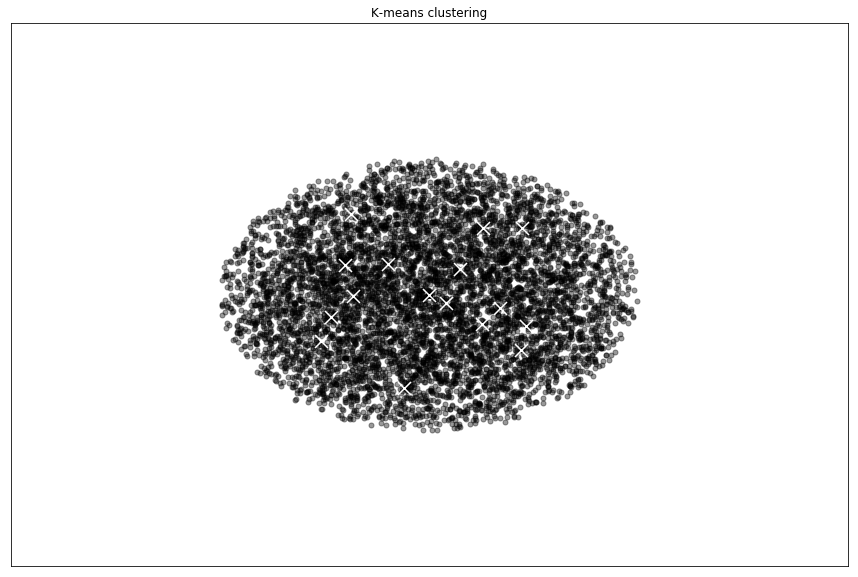

In [279]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .028    # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

plt.figure(figsize=(15, 10))
plt.plot(X[:, 0], X[:, 1], 'k.', markersize=10, alpha=0.4)

# Plot the centroids as a white X
centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=1,
            color='w', zorder=10)
plt.title('K-means clustering')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [280]:
clusters = {i: df.loc[np.where(km.labels_ == i)[0], 'bio'] for i in range(km.n_clusters)}

In [286]:
clusters[11]

7        Director AI Tesla Previously Research Scientis...
9          Interested Music Tech Scifi Future Humour Books
79       PhD Student UniofOxford Oxford DeepMindAI Scho...
123      Reimagining tech news reviews events Brought w...
136      CEO ChopDawgStudios Passionate student entrepr...
139      L ns T df Tweets I worst car opinions Wife gra...
184      The official Twitter page Microsoft consumer p...
207      Remote Python job board aggregator Find remote...
217                                        Phd Student JHU
224      Programmer musician addicted learning Loves Py...
244      Mentor na wildtech br I see great people I con...
255      Machine Learning Engineer Software Engineer em...
274      Research Fellow Machine Learning University Ca...
285      We one simple goal motivate give extra push ac...
294                                     Computer Scientist
302      PhD Student Machine Learning Recommender Syste...
306                                                  tes